## Import models from Hugging Face and MMDetection hub
This sample shows how to import and register models from [HuggingFace hub](https://huggingface.co/models).

For `image-object-detection` and `image-instance-segmentation`, models from MMDetection are supported. Please refer to [import_mmdetection_model_into_registry.ipynb](./import_mmdetection_model_into_registry.ipynb) to import these.

### How does import work?
The import process runs as a job in your AzureML workspace using components from the `azureml` system registry. The models are downloaded and converted to MLflow packaged format. You can then register the models to your AzureML Workspace or Registry that makes them available for inference or fine tuning. 

### What models are supported for import?
Any model from Hugging Face hub can be downloaded using the `download_model` component. Only the following set of tasks are supported for MLflow conversion:
* fill-mask
* token-classification
* question-answering
* summarization
* text-generation
* text-classification
* translation
* image-classification

Please note that, we also support `image-object-detection` and `image-instance-segmentation` models from MMDetection. To import these, refer to [import_mmdetection_model_into_registry.ipynb](./import_mmdetection_model_into_registry.ipynb).

### Limitations of Model Import component where MLFlow conversion of model(s) would fail: 
1. If you attempt to download a model that has a task type other than the above with error - `Exception: Unsupported task {task name}`. 
2. If Hugging Face model is on transformers version > 4.28.1. 
3. If Hugging Face model requires additional dependencies not covered in [requirements.txt](./requirements.txt)
4. If Hugging Face model requires custom tokenizer or custom Model architecture which can't be sufficied with transformers AutoTokenizer or AutoModel class.


### Why convert to MLflow?
MLflow is AzureML's recommended model packaging format. 
* **Evaluation benefits**: Foundation models imported and converted to MLflow format can be Evaluated using AzureML's Evaluation pipelines. You can use the no-code UI wizards, or the code-based job submission with the SDK or CLI/YAML. AzureML's Evaluation pipelines are built using components. This gives you the flexibility to compose your own Evaluation pipelines using AzureML Evaluation Components and evaluate your Model's performance on standard or custom dataset(s) to take informed decision on whether to deploy the base model directly or further fine-tune it before deployment. Learn more about AzureML Evaluation pipelines using [SDK](https://github.com/Azure/azureml-examples/tree/mabables/foundation-models/sdk/python/foundation-models/system/evaluation) or [CLI](https://github.com/Azure/azureml-examples/tree/mabables/foundation-models/cli/foundation-models/system/evaluation).
* **Inference benefits**: AzureML supports no-code-deployment for models packaged as MLflow that enables a seamless inference experience for the models. Learn more about [MLflow model packaging](https://learn.microsoft.com/en-us/azure/machine-learning/concept-mlflow-models) and [no-code-deployment](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-mlflow-models-online-endpoints?tabs=sdk). 
* **Fine tuning benefits**: Foundation models imported and converted to MLflow format can be fine tuned using AzureML's fine tuning pipelines. You can use the no-code UI wizards, or the code based job submission with the SDK or CLI/YAML. AzureML's fine tuning pipelines are built using components. This gives you the flexibility to compose your own fine tuning pipelines containing your own jobs for data transformation, post processing and the AzureML fine tuning components. Learn more about pipelines using [sdk](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipeline-python) or [CLI](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-component-pipelines-cli).

### What happens if I just download model and register models without converting to MLflow? That's because the task of the model I'm interested in is not among the supported list of tasks.
You can still download and register the model using the outputs of the `download_model` job. You need to [write your own inference code](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-deploy-online-endpoints?tabs=python) in this case. It also means that fine tuning is not yet supported if the task type of the model you are interested in is not in the supported list.

### Outline
1. Connect to Azure Machine Learning Workspace
2. Create a pipeline job using the pipeline component for HuggingFace models
3. Get the registered model


**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription - [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace with computer cluster - [Configure workspace](https://aka.ms/azureml-workspace-configuration)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](https://aka.ms/azureml-sdkv2-install) - check the getting started section


**Motivations** - This notebook explains how to create model importing/publishing pipeline job in workspace using pipeline component registered in a registry

## 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section, we will connect to the workspace in which the job will be run.

### 1.1 Import the required libraries

In [ ]:
# Import required libraries
from azure.ai.ml import MLClient, UserIdentityConfiguration
from azure.identity import (
    DefaultAzureCredential,
    InteractiveBrowserCredential,
)
from azure.ai.ml.dsl import pipeline

### 1.2 Configure credential

We are using `DefaultAzureCredential` to get access to the workspace. 
`DefaultAzureCredential` should be capable of handling most Azure SDK authentication scenarios. 

Reference for more available credentials if it does not work for you: [configure credential example](https://aka.ms/azureml-workspace-configuration), [azure-identity reference doc](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

In [ ]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

### 1.3 Get a handle to the workspace and the registry

We use the config file to connect to a workspace. The Azure ML workspace should be configured with a computer cluster. [Check this notebook for configure a workspace](https://aka.ms/azureml-workspace-configuration)

If config file is not available user can update following parameters in place holders
- SUBSCRIPTION_ID
- RESOURCE_GROUP
- WORKSPACE_NAME

In [ ]:
# Get a handle to workspace
try:
    ml_client_ws = MLClient.from_config(credential=credential)
except:
    ml_client_ws = MLClient(
        credential,
        subscription_id="<SUBSCRIPTION_ID>",
        resource_group_name="<RESOURCE_GROUP>",
        workspace_name="<WORKSPACE_NAME>",
    )

ml_client_registry = MLClient(credential, registry_name="azureml")

experiment_name = f"Import-Model-Pipeline"

### 1.4 Compute target setup

#### Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [ ]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "model-import-cluster"

try:
    _ = ml_client_ws.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="STANDARD_NC4AS_T4_V3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=6,
    )
    ml_client_ws.begin_create_or_update(compute_config).result()

## 2. Create a pipeline job using the pipeline component for HuggingFace models

### 2.1 Load pipeline component from the registry to create a pipeline

- import_model - Pipeline component which downloads the model, converts it into mlflow, validates locally and then register it.


In [ ]:
import_model = ml_client_registry.components.get(name="import_model", label="latest")

### 2.2 Create pipeline object using necessary parameters


#### Important parameters to pass
- model_id                                
- compute - Compute cluster on which pipeline job will run
- registry_name (optional) - By default, model is imported into your workspace. If registry_name is passed, the pipeline will attempt to register into respective registry

#### model_id 

Browse models on [HuggingFace hub](https://huggingface.co/models) and identify a model to import. Make sure the task type of the model is among the supported tasks as explained in the introduction section. Copy the model id which is available in the URI of the page or can be copied using the copy icon next to the model name and assign it to the variable `MODEL_ID`.


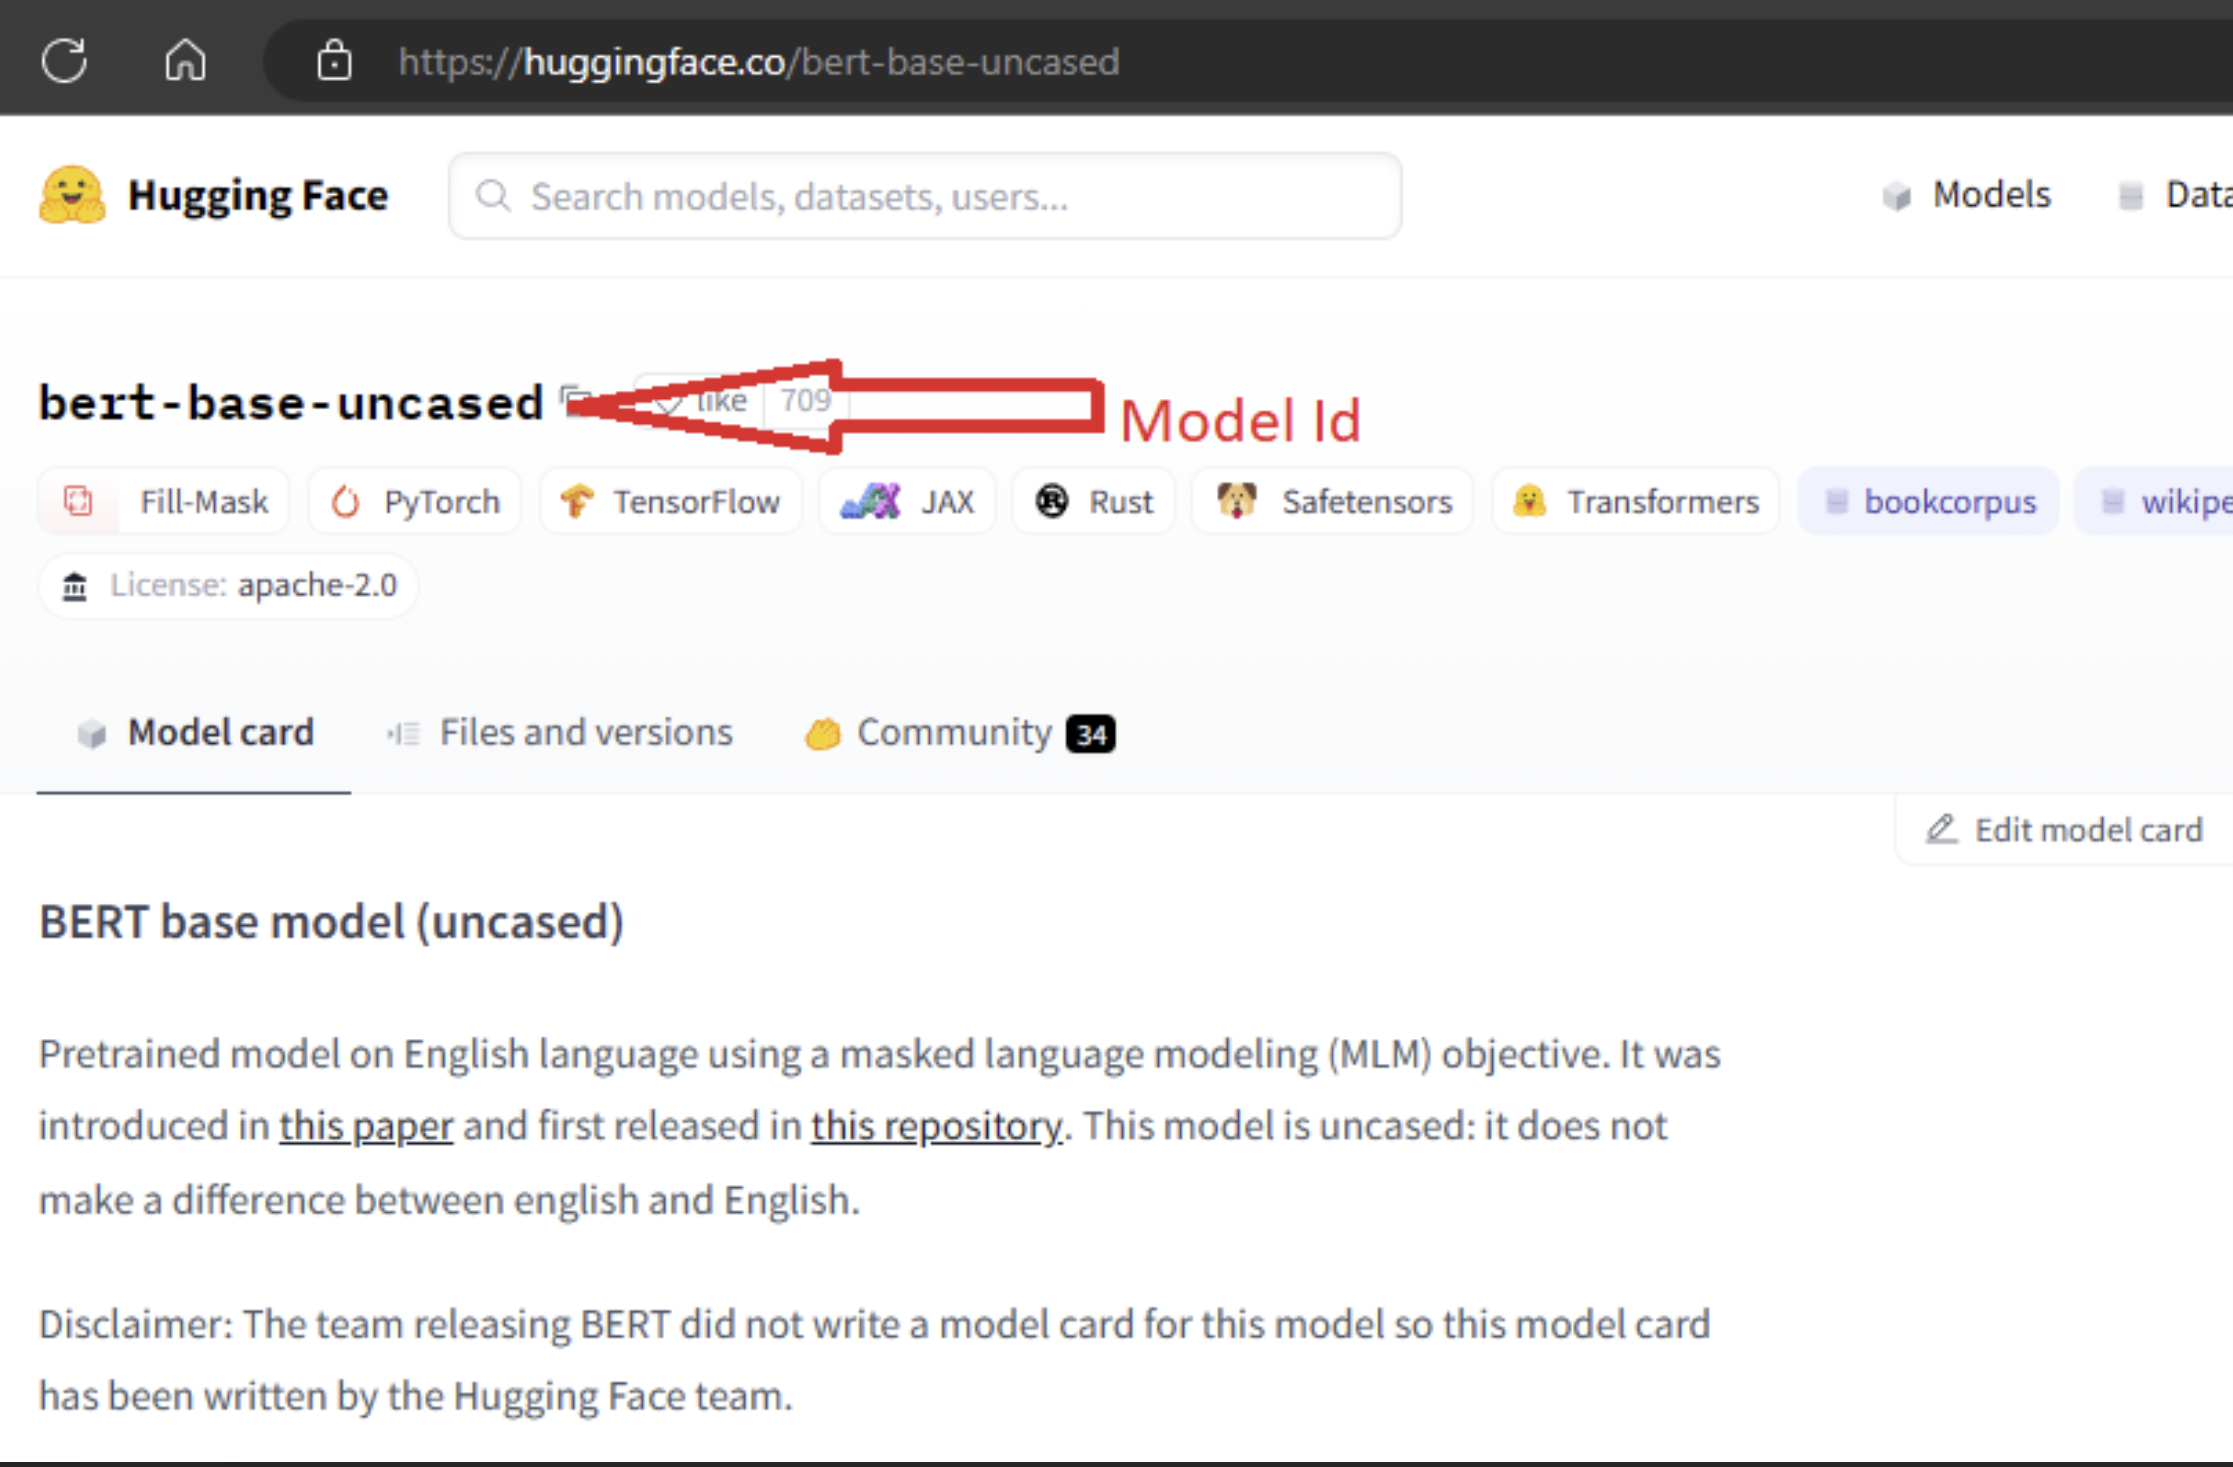


#### token

There are a few gated models hosted in HuggingFace, for example the [tiiuae/falcon-180B](https://huggingface.co/tiiuae/falcon-180B) model, which requires the user to accept certain terms and conditions, without which the import component cannot access it directly. To do so, the user would have to create a personal account in HuggingFace and accept terms and conditions. To import such models the user would have to create an Access Token with their HuggingFace account and pass it to the model-import component, after which the model can be downloaded to their workspace or registry. To know the more details , please visit [this link](https://huggingface.co/docs/hub/security-tokens).

__NOTE: Models from Hugging Face or MMDetection are subject to third party license terms available on the Hugging Face model details page or MMDetection model details page respectively. It is your responsibility to comply with the model's license terms.__
#### Set parameter values


In [ ]:
MODEL_ID = "google-bert/bert-base-uncased"
TASK_NAME = "fill-mask"
TOKEN = None

In [ ]:
# Check if the MODEL_ID passed is a valid HuggingFace ID
from huggingface_hub import HfApi, ModelFilter

hf_api = HfApi()  # by default endpoint points to https://huggingface.co
model_infos = [
    info
    for info in hf_api.list_models(filter=ModelFilter(model_name=MODEL_ID))
    if info.modelId == MODEL_ID
]

valid_hf_id = False
if model_infos and model_infos[0].modelId == MODEL_ID:
    valid_hf_id = True

if not valid_hf_id:
    raise ValueError(
        "Found invalid HF ID. Please select the correct HF ID and try again."
    )

In [ ]:
COMPUTE = compute_name

#### Check if the model already exists in AzureML registry

In [ ]:
huggingface_model_exists_in_registry = False
try:
    REG_MODEL_ID = MODEL_ID.replace(
        "/", "-"
    )  # model name in registry doesn't contain '/'
    models = ml_client_registry.models.list(name=REG_MODEL_ID)
    if models:
        max_version = (max(models, key=lambda x: int(x.version))).version
        model_version = str(int(max_version))
        print(
            f"Model already exists in azureml with name {REG_MODEL_ID} and version {model_version}"
        )
        huggingface_model_exists_in_registry = True
except:
    print(
        f"Model {MODEL_ID} has not been imported into the registry. Please continue importing the model."
    )

### 2.3 Create pipeline using pipeline component

In [ ]:
@pipeline
def model_import_pipeline(model_id, compute, task_name, token=None):
    """
    Create model import pipeline using pipeline component.

    Parameters
    ----------
    model_id : str
    compute : str
    task_name : str
    token : str

    Returns
    -------
    model_registration_details : dict
    """
    import_model_job = import_model(
        model_id=model_id, compute=compute, task_name=task_name, token=token
    )

    # Set job to not continue on failure
    import_model_job.settings.continue_on_step_failure = False

    return {
        "model_registration_details": import_model_job.outputs.model_registration_details
    }

### 2.4 Create pipeline object
Assign User Identity Configuration to pipeline object, so that individual pipeline components can get identity credentials if required. 
Click [here](https://learn.microsoft.com/en-us/samples/azure/azureml-examples/azureml---on-behalf-of-feature/) to know more about OBO credentials.

In [ ]:
pipeline_object = model_import_pipeline(
    model_id=MODEL_ID, compute=COMPUTE, task_name=TASK_NAME, token=TOKEN
)
pipeline_object.identity = UserIdentityConfiguration()

pipeline_object.settings.force_rerun = True


pipeline_object.settings.default_compute = COMPUTE

### 2.5 Submit model importing pipeline job

In [ ]:
schedule_huggingface_model_import = (
    not huggingface_model_exists_in_registry
    and MODEL_ID not in [None, "None"]
    and len(MODEL_ID) > 1
)
print(
    f"Need to schedule run for importing {MODEL_ID}: {schedule_huggingface_model_import}"
)

In [ ]:
huggingface_pipeline_job = None
if schedule_huggingface_model_import:
    # submit the pipeline job
    huggingface_pipeline_job = ml_client_ws.jobs.create_or_update(
        pipeline_object, experiment_name=experiment_name
    )
    # wait for the pipeline job to complete
    ml_client_ws.jobs.stream(huggingface_pipeline_job.name)

## 3. Get the registered model

### 3.1 Download model registration details in local file

In [ ]:
import os
import shutil

download_path = "./pipeline_outputs/"

# delete the folder if already exists
if os.path.exists(download_path):
    shutil.rmtree(download_path)

# if pipeline job was not scheduled, skip
if huggingface_pipeline_job is not None:
    print("Pipeline job: " + huggingface_pipeline_job.name)
    print("Downloading pipeline job output: model_registration_details")

    pipeline_download_path = os.path.join(download_path, huggingface_pipeline_job.name)
    os.makedirs(pipeline_download_path, exist_ok=True)

    ml_client_ws.jobs.download(
        name=huggingface_pipeline_job.name,
        download_path=pipeline_download_path,
        output_name="model_registration_details",
    )

### 3.2 Read registration details and get model from registry/workspace

In [ ]:
import json

# if pipeline job was not scheduled, skip
if huggingface_pipeline_job is not None:
    with open(
        f"./pipeline_outputs/{huggingface_pipeline_job.name}/named-outputs/model_registration_details/model_registration_details.json",
        "r",
    ) as f:
        registration_details = json.load(f)

    model_name = registration_details["name"]
    model_version = registration_details["version"]

    # Get the model object from workspace
    model = ml_client_ws.models.get(name=model_name, version=model_version)
    print(f"\n{model_name}")
    print(model.__dict__)